<a href="https://colab.research.google.com/github/stevejj4/Insurance-data-lifecycle/blob/main/Policies_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install google-cloud-bigquery
!pip install pyspark==3.1.2

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd
from pyspark.sql import SparkSession


In [35]:
# Authenticating and initializing BigQuery client
project_id = 'river-messenger-430112-e1'
client = bigquery.Client(project=project_id)

In [36]:
# Querying to get interactions table
query_policies = """
SELECT * FROM `river-messenger-430112-e1.Insurance_data.policies`;
"""

In [37]:
# Executing the query and converting to a pandas DataFrame
df_policies = client.query(query_policies).to_dataframe()

In [38]:
# Initializing SparkSession
spark = SparkSession.builder \
    .appName('BigQuerySparkApp') \
    .getOrCreate()

# Converting pandas DataFrame to Spark DataFrame
# Using iterrows() instead of iteritems() to iterate over DataFrame rows
spark_df_policies = spark.createDataFrame(df_policies.to_dict('records'))

# Show the schema and first few rows
spark_df_policies.printSchema()
spark_df_policies.show(5)

root
 |-- CustomerID: long (nullable = true)
 |-- PolicyEndDate: string (nullable = true)
 |-- PolicyID: long (nullable = true)
 |-- PolicyStartDate: string (nullable = true)
 |-- PolicyType: string (nullable = true)
 |-- PremiumAmount: double (nullable = true)

+----------+-------------+--------+---------------+----------+-------------+
|CustomerID|PolicyEndDate|PolicyID|PolicyStartDate|PolicyType|PremiumAmount|
+----------+-------------+--------+---------------+----------+-------------+
|         3|   2025-08-18|       3|     2023-07-07|      Auto|      3644.16|
|         9|   2024-09-12|       9|     2023-05-27|      Auto|      4010.11|
|        24|   2025-10-21|      24|     2023-10-04|      Auto|      3700.61|
|        27|   2027-04-21|      27|     2021-12-18|      Auto|      1838.51|
|        29|   2026-05-21|      29|     2023-09-01|      Auto|      1507.74|
+----------+-------------+--------+---------------+----------+-------------+
only showing top 5 rows



In [39]:
from pyspark.sql.functions import col, count, when, isnull, mean # Import the mean function

# Check for missing values in each column
spark_df_policies.select([count(when(isnull(c), c)).alias(c) for c in spark_df_policies.columns]).show()

# Handle missing values
# Example: Fill missing PremiumAmount with the average premium
mean_premium = spark_df_policies.select(mean(col("PremiumAmount"))).collect()[0][0]
spark_df_policies = spark_df_policies.fillna(mean_premium, subset=["PremiumAmount"])

# Check for inconsistencies
# Example: Check if PolicyEndDate is always after PolicyStartDate
inconsistent_dates = spark_df_policies.filter(col("PolicyEndDate") < col("PolicyStartDate"))
inconsistent_dates.show()

# Handle inconsistencies
# Example: Drop rows with inconsistent dates
spark_df_policies = spark_df_policies.filter(col("PolicyEndDate") >= col("PolicyStartDate"))

+----------+-------------+--------+---------------+----------+-------------+
|CustomerID|PolicyEndDate|PolicyID|PolicyStartDate|PolicyType|PremiumAmount|
+----------+-------------+--------+---------------+----------+-------------+
|         0|            0|       0|              0|         0|            0|
+----------+-------------+--------+---------------+----------+-------------+

+----------+-------------+--------+---------------+----------+-------------+
|CustomerID|PolicyEndDate|PolicyID|PolicyStartDate|PolicyType|PremiumAmount|
+----------+-------------+--------+---------------+----------+-------------+
+----------+-------------+--------+---------------+----------+-------------+



In [40]:
from pyspark.sql.functions import datediff, when, col, sum

# Calculate policy duration in days
spark_df_policies = spark_df_policies.withColumn("PolicyDuration", datediff(col("PolicyEndDate"), col("PolicyStartDate")))

# Categorize policies based on duration
spark_df_policies = spark_df_policies.withColumn("DurationCategory",
                                              when(col("PolicyDuration") <= 365, "Short-term")
                                             .when((col("PolicyDuration") > 365) & (col("PolicyDuration") <= 730), "Mid-term")
                                             .otherwise("Long-term"))

# Aggregate features: Total premium paid per customer
spark_df_customer_premiums = spark_df_policies.groupBy("CustomerID").agg(sum("PremiumAmount").alias("TotalPremiumPaid"))

# Join aggregate features back to main DataFrame (if needed)
spark_df_policies = spark_df_policies.join(spark_df_customer_premiums, "CustomerID")

In [47]:
spark_df_policies = spark_df_policies.drop("PolicyEndDate", "PolicyStartDate") #to redeuce redundancy

In [48]:
spark_df_policies.show(5)

+----------+--------+----------+-------------+--------------+----------------+----------------+
|CustomerID|PolicyID|PolicyType|PremiumAmount|PolicyDuration|DurationCategory|TotalPremiumPaid|
+----------+--------+----------+-------------+--------------+----------------+----------------+
|        26|      26|      Life|       1306.6|          1274|       Long-term|          1306.6|
|        29|      29|      Auto|      1507.74|           993|       Long-term|         1507.74|
|       474|     474|      Life|       3890.9|          2456|       Long-term|          3890.9|
|       964|     964|      Home|      4950.97|           420|        Mid-term|         4950.97|
|      1677|    1677|      Auto|       4742.6|          3033|       Long-term|          4742.6|
+----------+--------+----------+-------------+--------------+----------------+----------------+
only showing top 5 rows



+----------+-----+
|PolicyType|Count|
+----------+-----+
|    Health|  511|
|      Life|  500|
|      Home|  497|
|      Auto|  496|
+----------+-----+



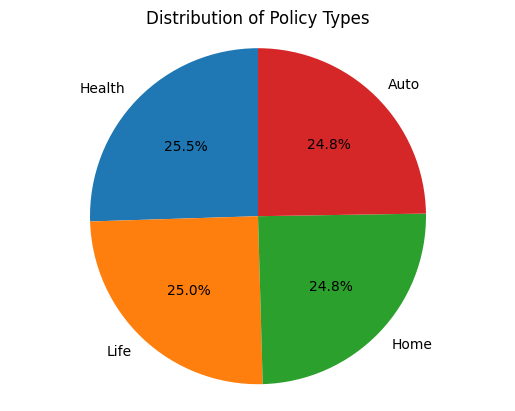

In [52]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import pandas as pd

# Count the occurrences of each policy type
policy_type_counts = spark_df_policies.groupBy("PolicyType").agg(count("*").alias("Count")).orderBy("Count", ascending=False)

# Display the results
policy_type_counts.show()

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_df = policy_type_counts.toPandas()

# Create the pie chart
plt.pie(pandas_df['Count'], labels=pandas_df['PolicyType'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Policy Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Premium Amount Summary:
Mean: 2988.8970359281425
Standard Deviation: 1154.4219822188297
Minimum: 1005.08
Maximum: 4998.18


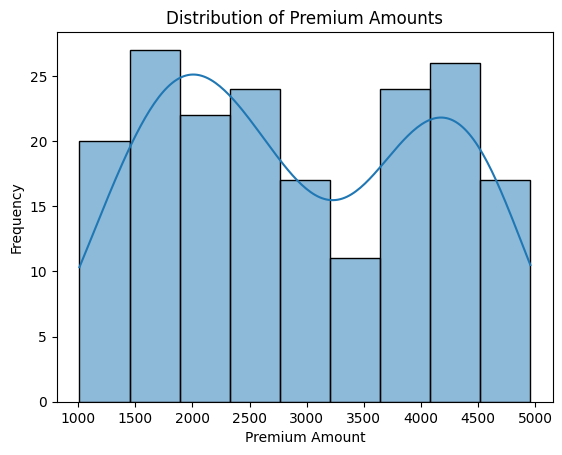

In [50]:
from pyspark.sql.functions import mean, stddev, min, max

# Calculate summary statistics
premium_summary = spark_df_policies.select(
    mean("PremiumAmount").alias("Mean"),
    stddev("PremiumAmount").alias("StdDev"),
    min("PremiumAmount").alias("Min"),
    max("PremiumAmount").alias("Max")
).collect()[0]

print("Premium Amount Summary:")
print(f"Mean: {premium_summary['Mean']}")
print(f"Standard Deviation: {premium_summary['StdDev']}")
print(f"Minimum: {premium_summary['Min']}")
print(f"Maximum: {premium_summary['Max']}")

# (Optional) Visualize with a histogram
import seaborn as sns

# Sample the data for visualization (if the dataset is large)
sample_df = spark_df_policies.sample(fraction=0.1, withReplacement=False).select("PremiumAmount").toPandas()

sns.histplot(sample_df['PremiumAmount'], kde=True)
plt.xlabel('Premium Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Premium Amounts')
plt.show()

In [ ]:
spark_df_policies = spark_df_policies.drop("PolicyEndDate", "PolicyStartDate") #to redeuce redundancy